In [1]:
import pandas as pd
import numpy as np
import os

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')

In [3]:
base_dir = 'data/english_only/prompting_results_clean/with_metrics/'

In [4]:
os.listdir(base_dir)

['llama3.1_70B_100_sample_with_metrics.jsonl',
 'wildchat_subset_en_2k_prompting_Mistral-7B-Instruct-v0.3-lexical.jsonl',
 'llama_3.1-70B_100_sample.jsonl',
 'wildchat_subset_en_2k_prompting_Mistral-7B-Instruct-v0.3.jsonl',
 'wildchat_subset_en_2k_prompting_Meta-Llama-3.1-8B-Instruct.jsonl',
 'mixtral_100_sample_with_metrics.jsonl',
 'mixtral_100_sample.jsonl',
 'wildchat_subset_en_2k_prompting_Meta-Llama-3.1-70B-Instruct.jsonl']

In [5]:
metrics = pd.read_json(base_dir+'llama_3.1-70B_100_sample.jsonl', orient='records', lines=True)
metrics = pd.read_json(base_dir+'mixtral_100_sample.jsonl', orient='records', lines=True)


In [6]:
metrics['metric_perplexity'] = 1/metrics['llm_perplexity'] - 1/metrics['human_perplexity']

In [7]:
Counter(metrics.human_turn_1.isna())

Counter({False: 100})

In [8]:
metrics = metrics[~metrics.human_turn_1.isna()]

In [9]:
[c for c in metrics.columns if c.startswith('metric')]

['metric_rouge',
 'metric_bleu',
 'metric_sentiment',
 'metric_formality',
 'metric_politeness',
 'metric_toxicity',
 'metric_readability',
 'metric_capitalization',
 'metric_contract_count',
 'metric_end',
 'metric_log_word_count',
 'metric_perplexity',
 'metric_pos',
 'metric_punctuation',
 'metric_sbert',
 'metric_topic',
 'metric_typo',
 'metric_word_length',
 'metric_grammar',
 'metric_liwc']

In [10]:
'metric_end'

lexical = ['metric_log_word_count',
           'metric_word_length',
           'metric_perplexity',
           'metric_contract_count',
           'metric_capitalization',
           'metric_typo',
          ]

syntactic = ['metric_grammar',
            'metric_punctuation',
            'metric_pos',
            #'metric_constituency_parse',
            ]

semantic = ['metric_sbert',
            'metric_rouge',
            #'metric_bleu',
            'metric_liwc',
            'metric_topic',
           ]

style = ['metric_sentiment',
         'metric_politeness',
         'metric_formality',
         'metric_toxicity',
         #'metric_facuality',
         'metric_readability',
         #'metric_subjectivity',
         #'metric_luar',
        ]


In [11]:
def normalize(x, method = 'minmax', center = True, pos_scale = True):
    x_norm = x
    
    # if remove_outlier == 'IQR':
    #     q1 = np.percentile(x_norm, 25)
    #     q3 = np.percentile(x_norm, 75)
    #     iqr = q3 - q1
    #     lower = q1 - 1.5*iqr
    #     upper = q3 + 1.5*iqr
    #     x_norm[x_norm < lower] = lower
    #     x_norm[x_norm > upper] = upper
    
    if method == 'zscore':
        if center: x_norm = x_norm - np.mean(x_norm)
        x_norm = x_norm / np.std(x_norm)
        
    if method == 'minmax':
        min_val = min(x_norm)
        max_val = max(x_norm)
        if pos_scale: x_norm = (x_norm - min_val)/(max_val - min_val)
        else: x_norm = 2*(x_norm - min_val)/(max_val - min_val) - 1
        
    return x_norm

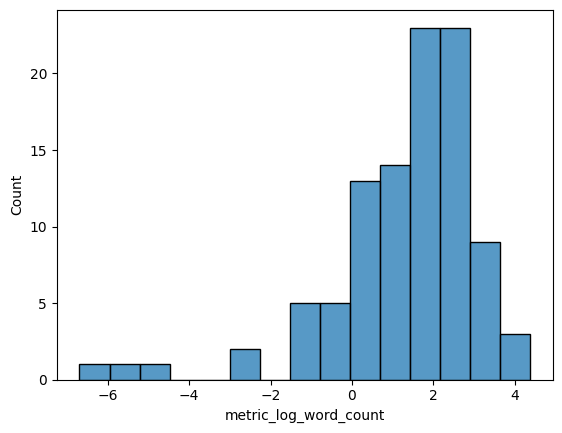

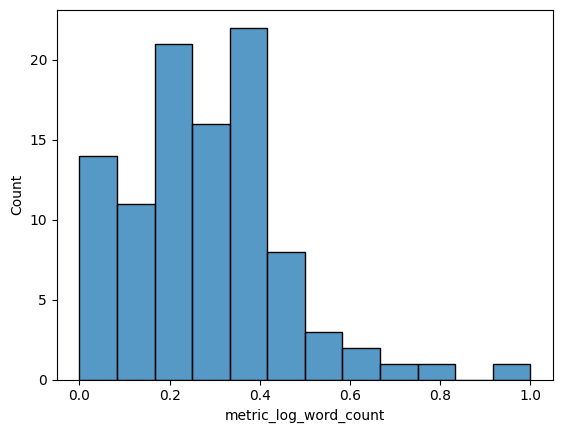

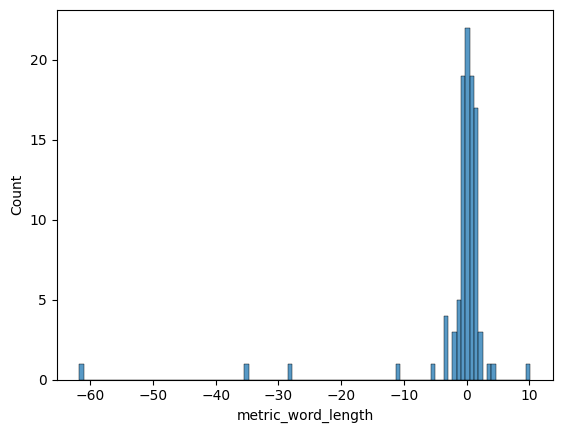

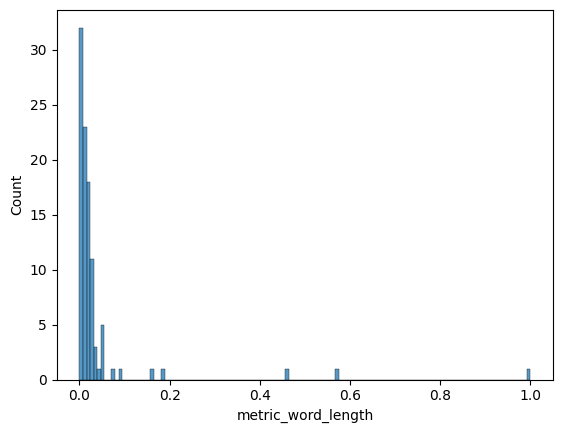

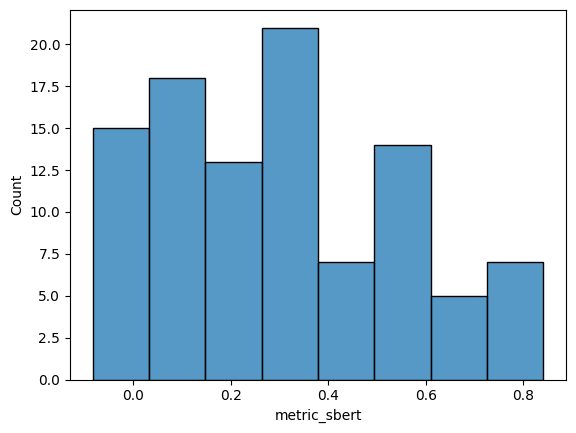

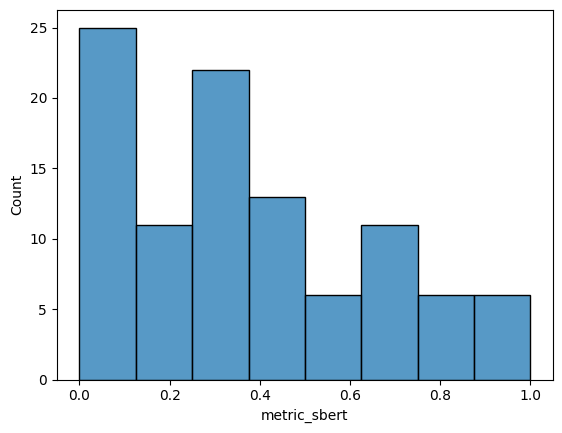

In [12]:
c = 'metric_sbert'
sns.histplot(metrics[c])
plt.show()
metrics[c] = normalize(metrics[c])
sns.histplot(metrics[c])
plt.show()

needs_normalization = ['metric_log_word_count', 'metric_word_length']
for c in needs_normalization:
    sns.histplot(metrics[c])
    plt.show()
    metrics[c] = normalize(abs(metrics[c]))
    sns.histplot(metrics[c])
    plt.show()


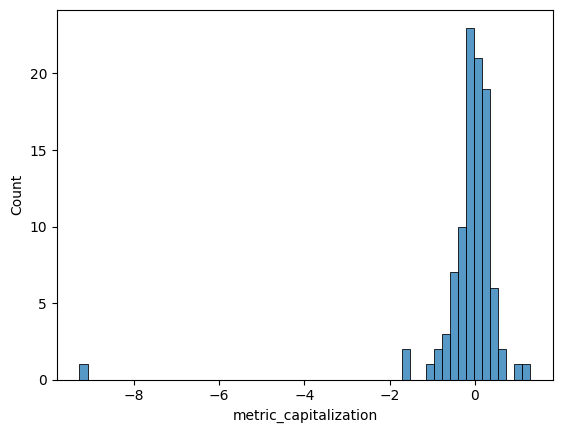

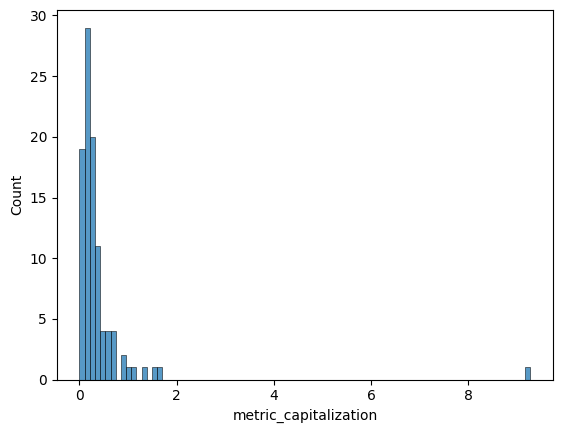

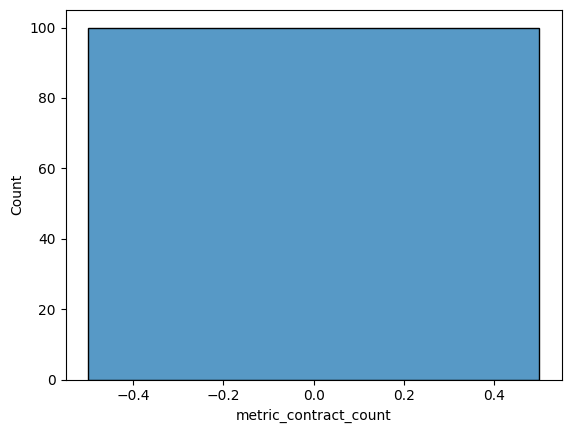

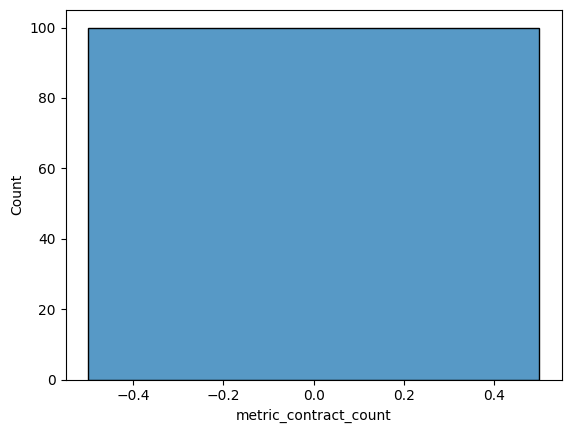

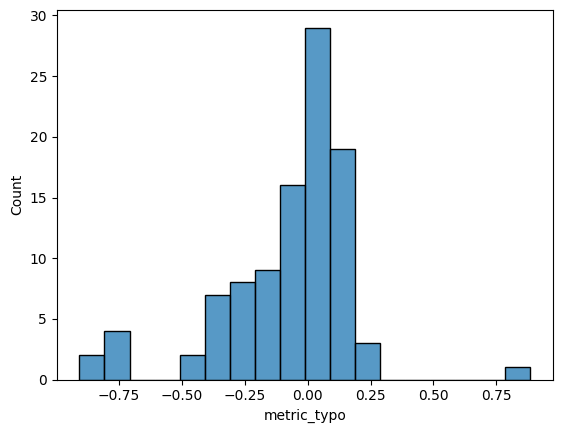

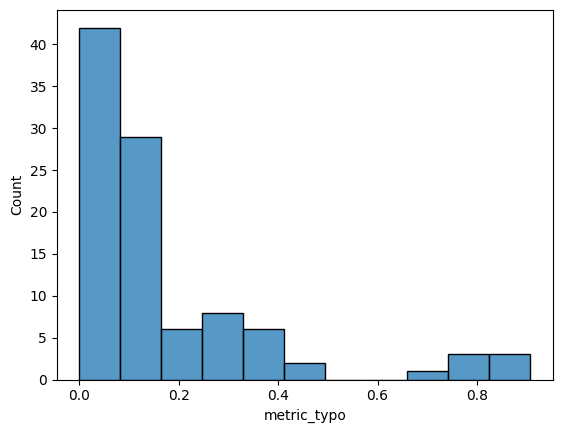

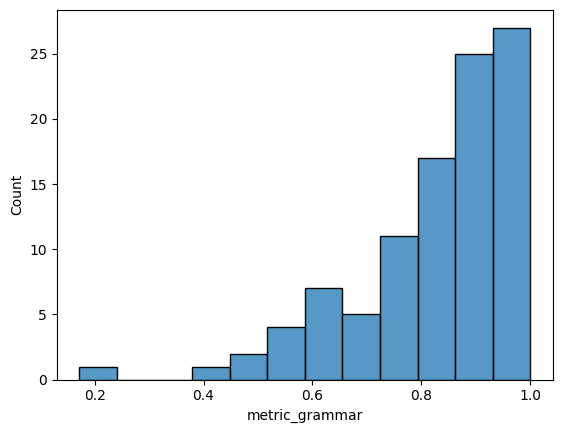

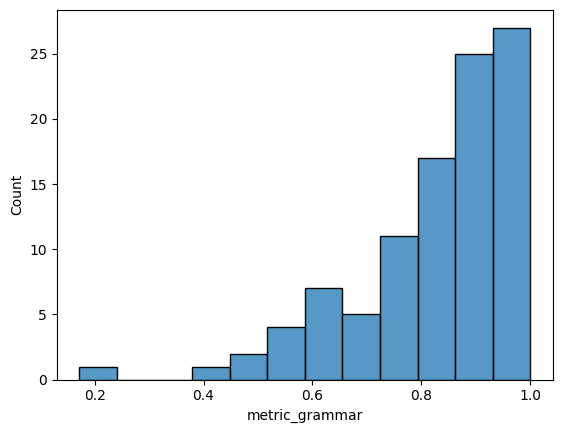

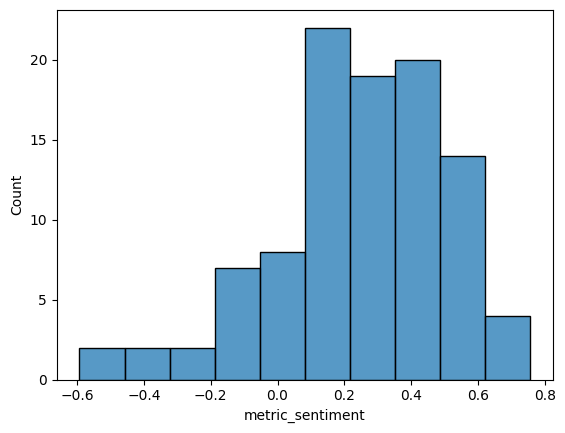

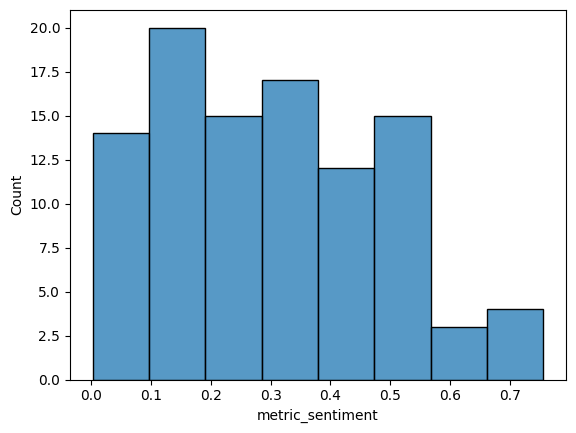

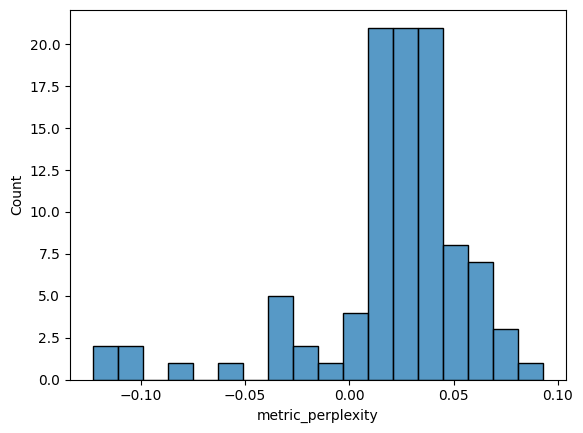

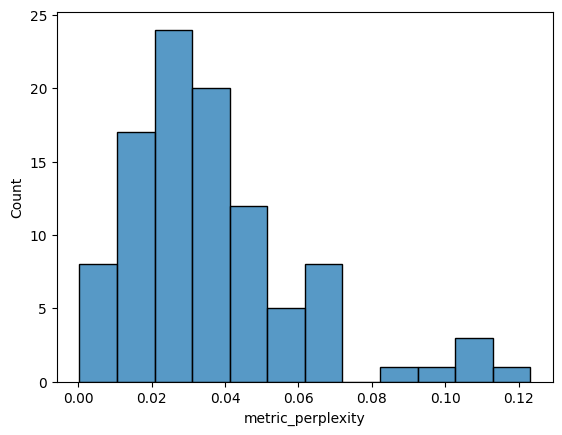

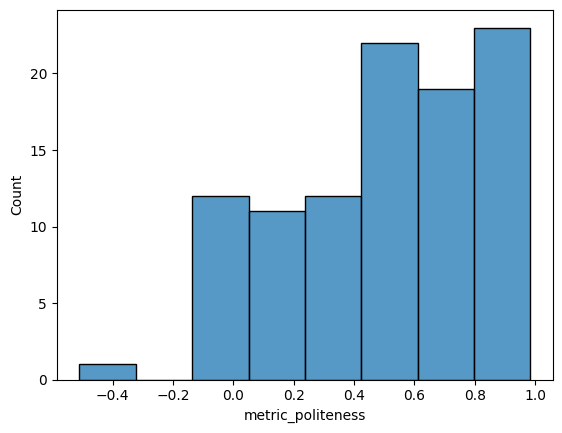

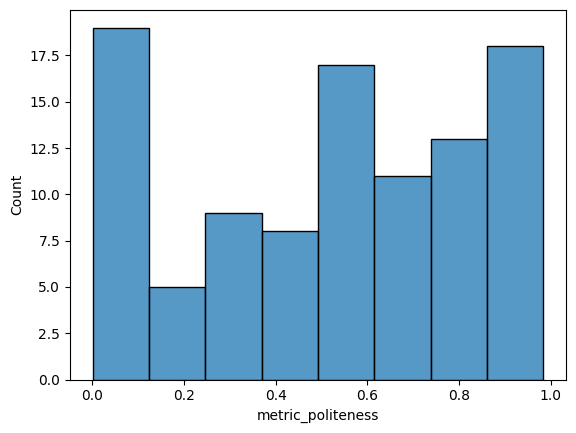

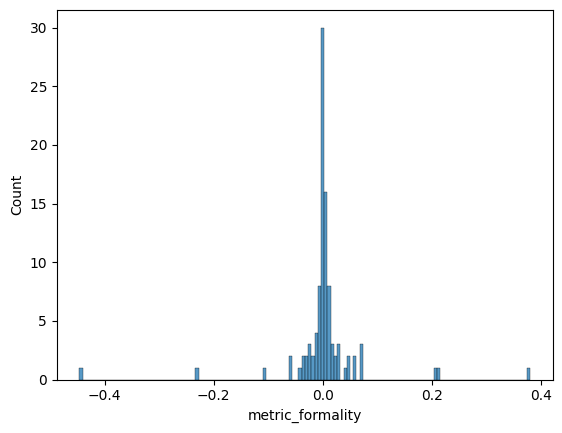

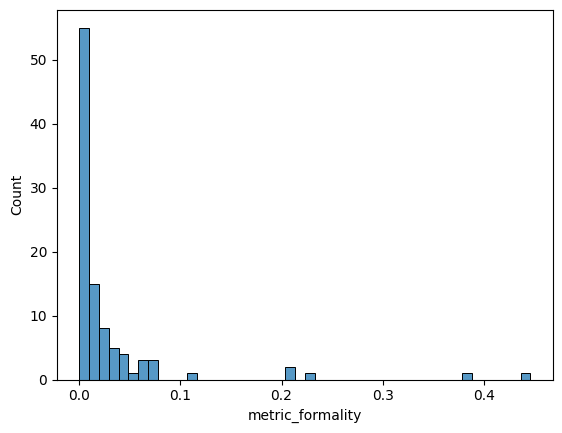

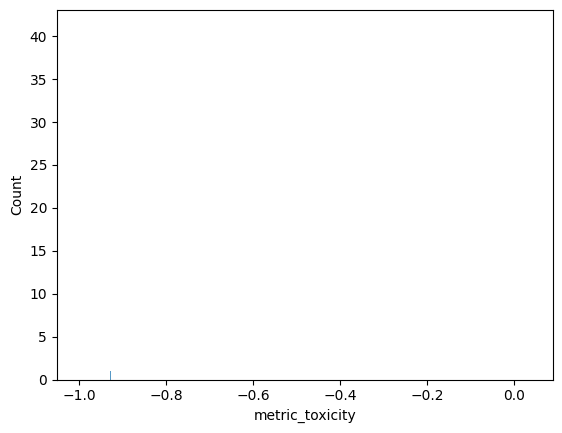

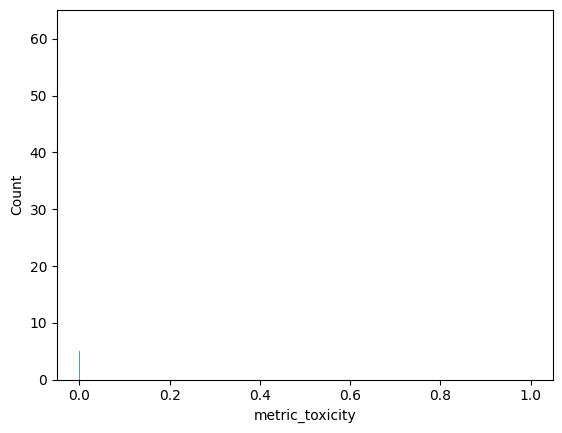

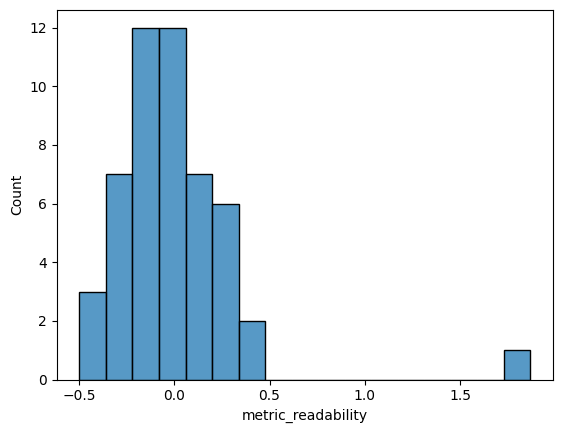

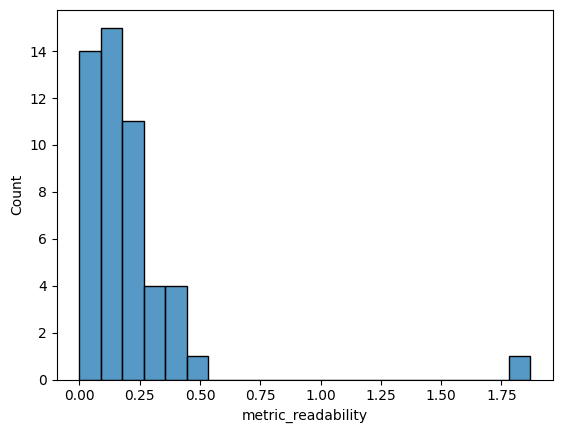

In [23]:
needs_abs_diff = ['metric_capitalization',
                 'metric_contract_count',
                 'metric_typo',
                 'metric_grammar',
                 'metric_sentiment',
                 'metric_perplexity',
                 'metric_politeness',
                 'metric_formality',
                 'metric_toxicity',
                 'metric_readability',
                 ]

for c in needs_abs_diff:
    sns.histplot(metrics[c])
    plt.show()
    metrics[c] = np.abs(metrics[c])
    sns.histplot(metrics[c])
    plt.show()


In [35]:
Counter(metrics['metric_toxicity']<0.01)

Counter({True: 92, False: 8})

In [24]:
'metric_end'

lexical = ['metric_log_word_count',
           'metric_word_length',
           'metric_capitalization',
           'metric_contract_count',
           'metric_typo',
          ]

syntactic = ['metric_grammar',
            'metric_punctuation',
            'metric_pos',
            ]

semantic = ['metric_sbert',
            'metric_rouge',
            #'metric_bleu',
            'metric_liwc',
            'metric_topic',
           ]

style = ['metric_sentiment',
         'metric_perplexity',
         'metric_politeness',
         'metric_formality',
         'metric_toxicity',
         'metric_readability',
        ]


In [25]:
metrics[lexical]

,metric_log_word_count,metric_word_length,metric_capitalization,metric_contract_count,metric_typo
0,0.296963,0.012593,0.139626,0,0.095339
1,0.242523,0.027109,0.238135,0,0.146341
2,0.018068,0.002675,0.056085,0,0.017857
3,0.005767,0.005484,0.117364,0,0.112281
4,0.125063,0.091652,0.415117,0,0.345501
...,...,...,...,...,...
95,0.486148,0.005318,0.074859,0,0.090909
96,0.217821,0.181951,1.553469,0,0.451286
97,0.238829,0.021379,0.126198,0,0.240000
98,0.119894,0.020633,0.387537,0,0.003661


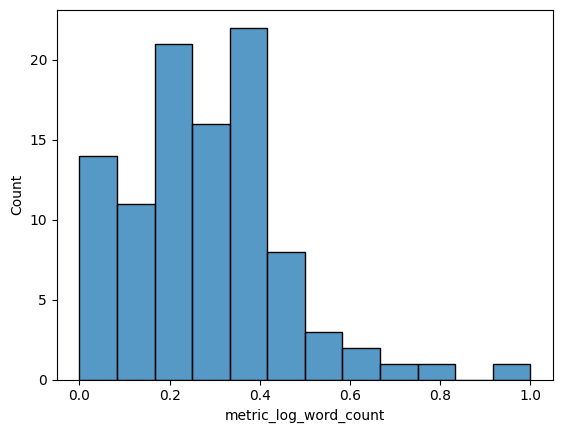

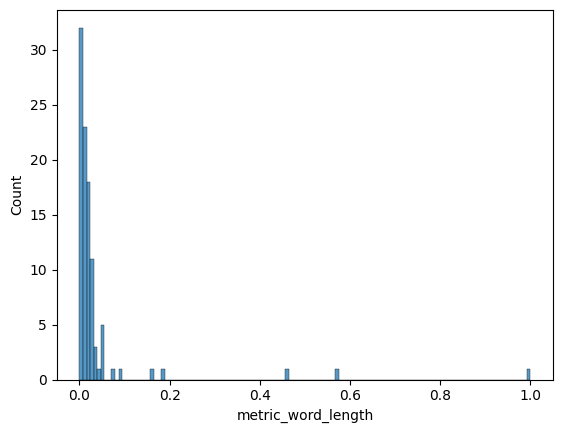

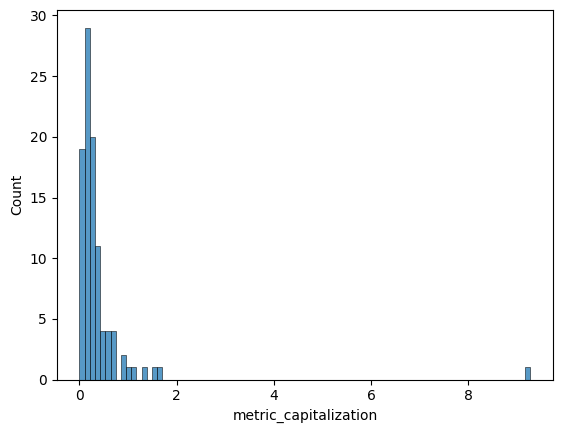

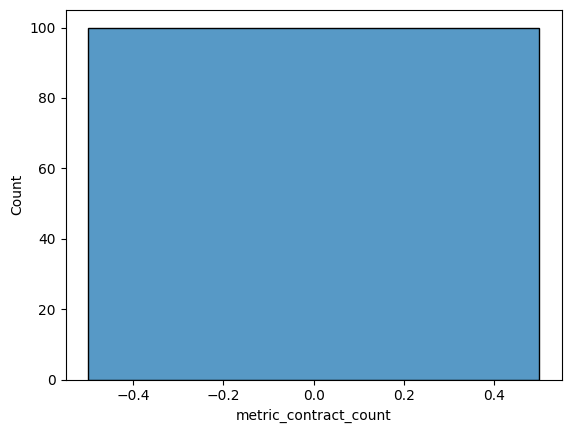

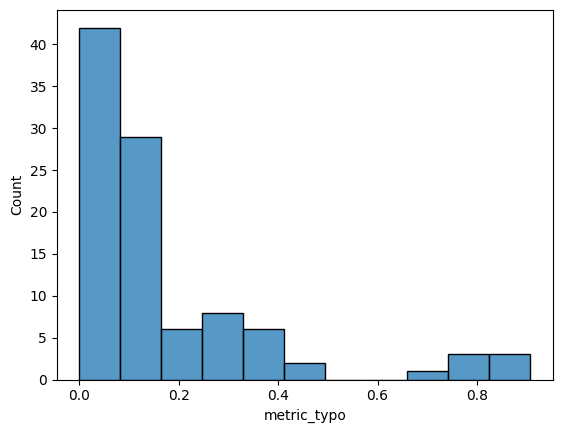

<Axes: xlabel='agg_lexical', ylabel='Count'>

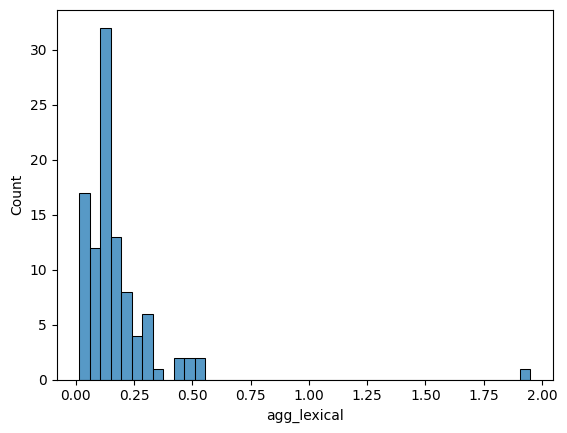

In [26]:
for c in lexical:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_lexical'] = metrics[lexical].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_lexical'])

In [27]:
metrics[syntactic]

,metric_grammar,metric_punctuation,metric_pos
0,0.934249,0.005568,0.703820
1,0.695663,0.002939,0.651648
2,1.000000,0.003205,0.641647
3,1.000000,0.003717,0.770967
4,0.594688,0.004712,0.544804
...,...,...,...
95,1.000000,0.002645,0.652933
96,0.497059,0.008061,0.537023
97,1.000000,0.003777,0.539093
98,0.883955,0.000893,0.832904


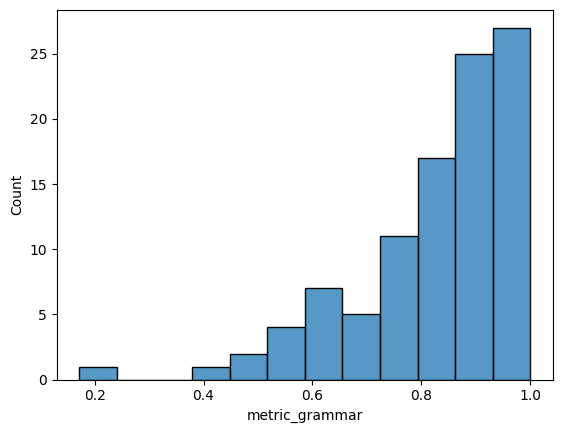

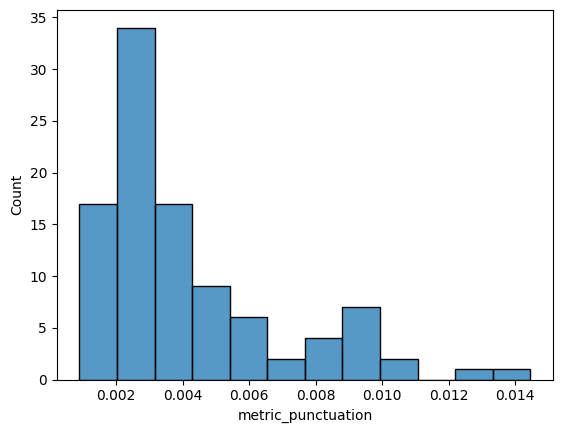

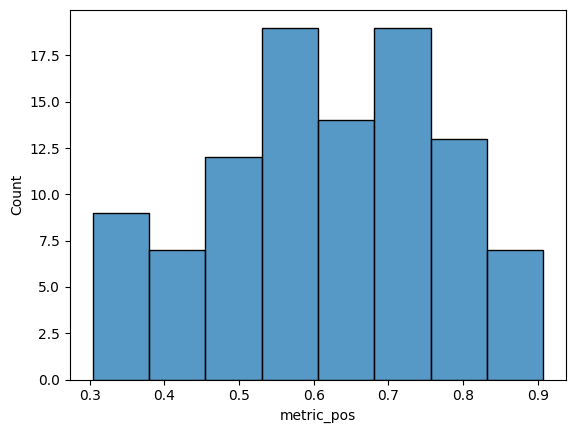

<Axes: xlabel='agg_syntactic', ylabel='Count'>

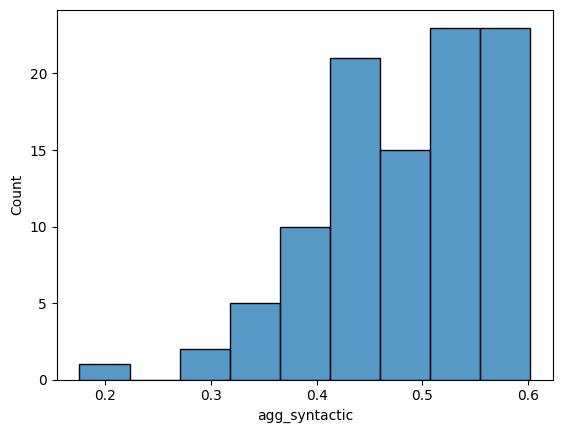

In [28]:
for c in syntactic:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_syntactic'] = metrics[syntactic].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_syntactic'])

In [29]:
metrics[semantic]

,metric_sbert,metric_rouge,metric_liwc,metric_topic
0,0.347515,0.058824,0.385109,0.811823
1,0.081964,0.078431,0.333804,0.895869
2,0.272460,0.129032,0.462810,0.773180
3,0.969610,0.218487,0.595589,0.718004
4,0.411693,0.045161,0.479382,0.661032
...,...,...,...,...
95,0.027545,0.017391,0.473003,0.556100
96,0.710637,0.134831,0.441383,0.719163
97,0.141627,0.200000,0.388502,0.664691
98,0.870024,0.101382,0.637940,0.824501


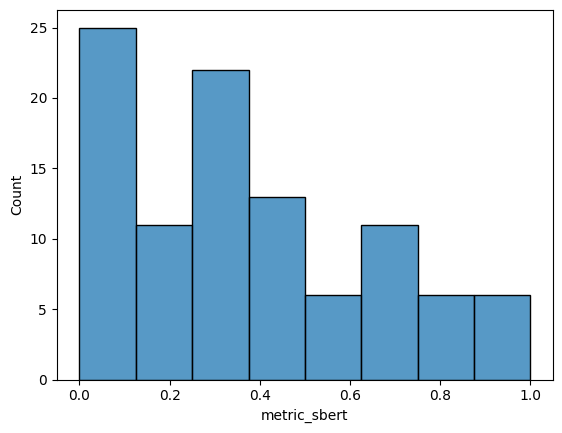

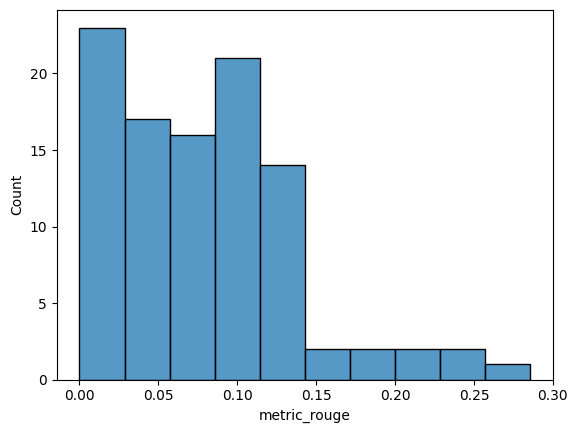

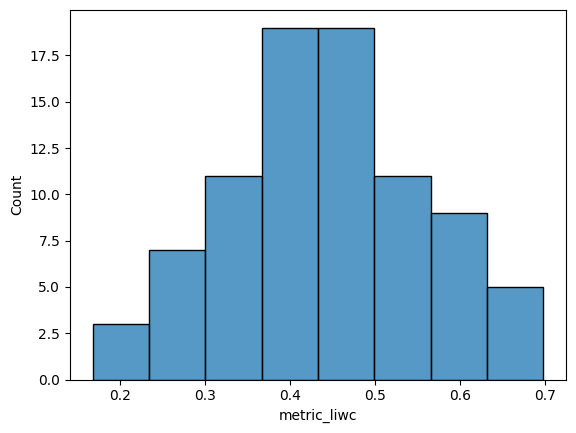

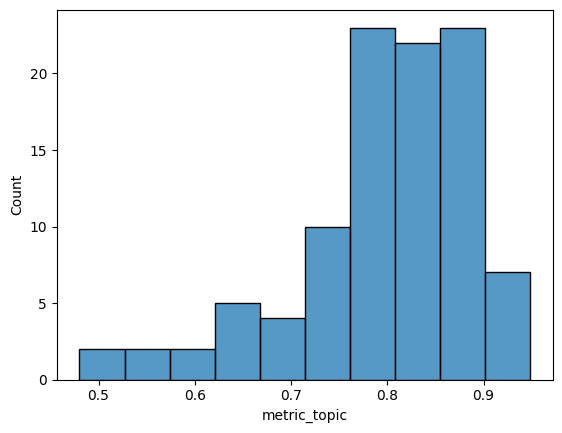

<Axes: xlabel='agg_semantic', ylabel='Count'>

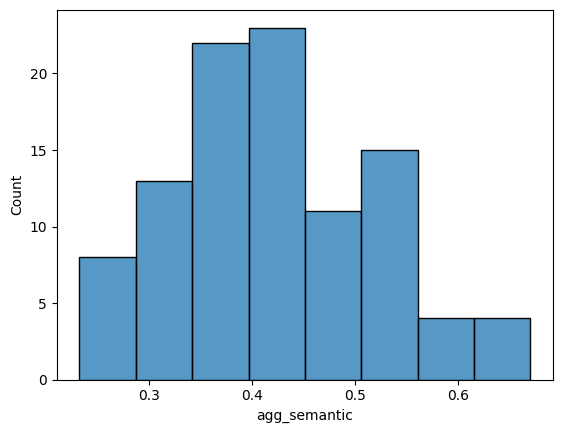

In [30]:
for c in semantic:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_semantic'] = metrics[semantic].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_semantic'])

In [31]:
metrics[style]

,metric_sentiment,metric_perplexity,metric_politeness,metric_formality,metric_toxicity,metric_readability
0,0.246448,0.019457,0.871820,0.043731,8.403808e-04,NaN
1,0.042305,0.014091,0.011156,0.020132,1.079500e-06,NaN
2,0.250664,0.014226,0.389551,0.446177,7.815600e-06,0.053909
3,0.154061,0.024155,0.244681,0.061844,9.873600e-06,0.144818
4,0.196634,0.123172,0.517019,0.001659,2.374380e-05,NaN
...,...,...,...,...,...,...
95,0.096997,0.070231,0.048338,0.001657,9.842000e-07,NaN
96,0.255761,0.051769,0.599798,0.057663,2.578330e-05,NaN
97,0.165555,0.023942,0.705541,0.000316,1.796139e-03,NaN
98,0.689501,0.070007,0.820478,0.004437,6.187990e-05,0.280545


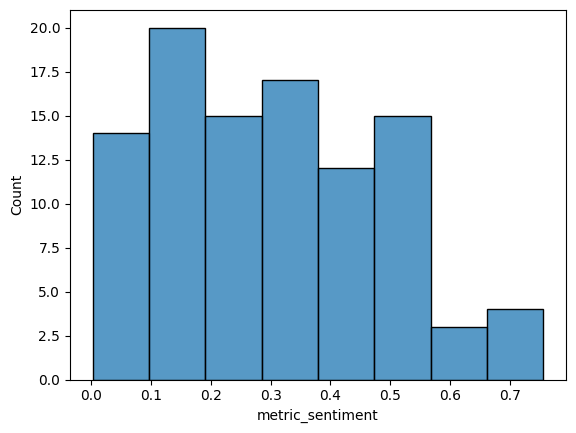

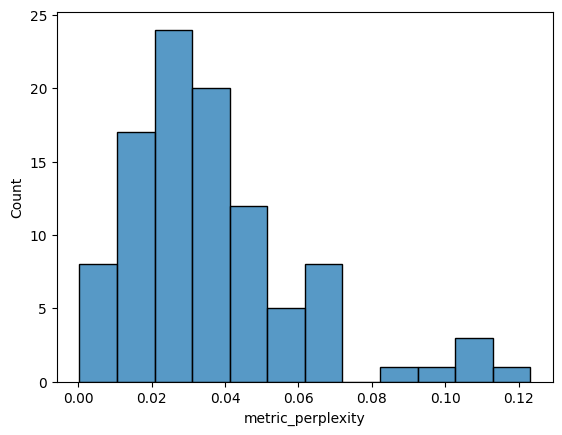

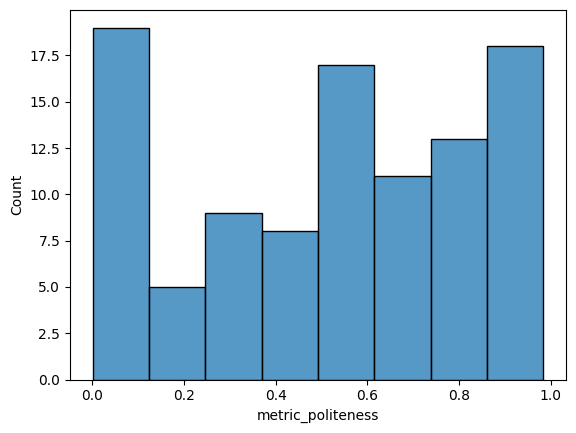

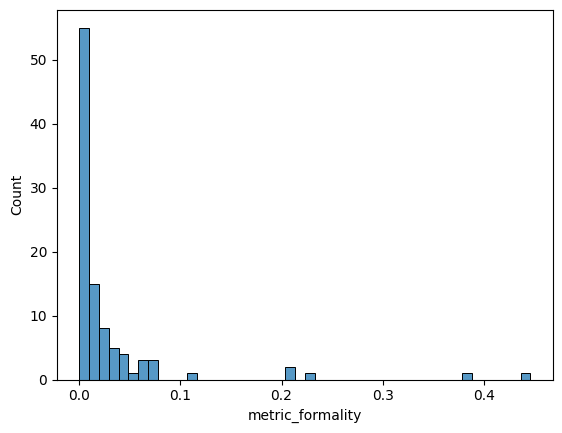

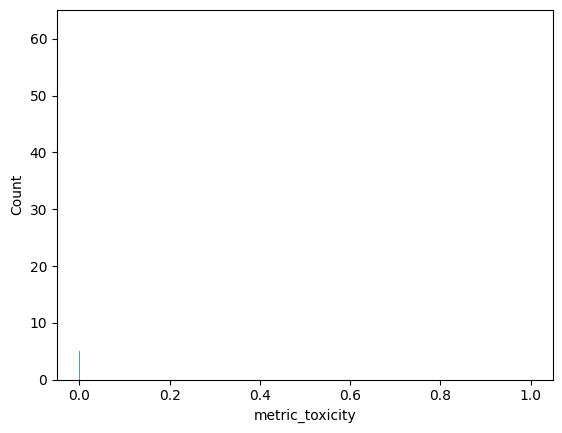

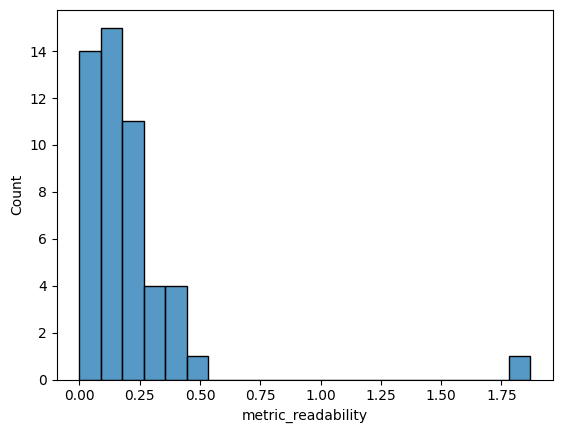

<Axes: xlabel='agg_style', ylabel='Count'>

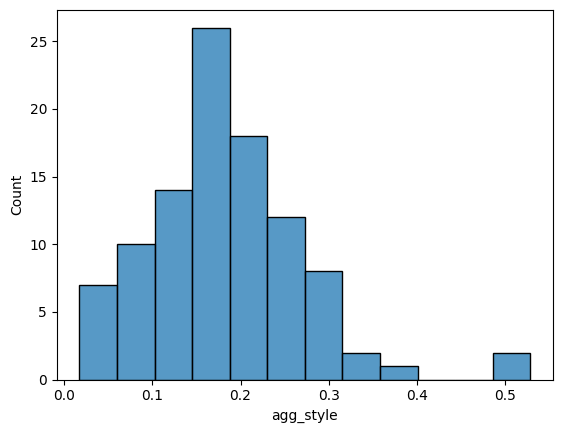

In [32]:
for c in style:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_style'] = metrics[style].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_style'])